# 01: Bag of Words

*The amoeba. The simplest possible "language model."*

---

This notebook builds a model with the architecture:

```
Input tokens → Embedding → Average → Unembed → Prediction
```

That's it. No position information. No attention. No communication between tokens. The model sees a *set* of words and guesses what word comes next based purely on "what words are present?"

**What we expect:** Word soup. The model will learn word frequencies and co-occurrence patterns, but it won't understand word order. Given "Once upon a time there was a girl named", it might output common TinyStories words like "the" or "and" rather than "Lily"—because it has no idea that "named" just happened.

**Why this matters:** By feeling the limitations of this model, we'll understand why position encoding (notebook 02) helps.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Load Data and Tokenizer

We use the data prepared in notebook 00.

**A note on tokenizers:** The tokenizer is completely separate from the model. They share *nothing* except the vocabulary size—the model needs to know "there are 4,096 possible token IDs" so it can make an embedding table of the right size. But the model has no idea what token 42 *means*. It's just index 42.

Our `LilTokenizer` wraps GPT-2's tokenizer because GPT-2 already did the hard work of learning good subword splits. We just remap the IDs to a smaller range (0-4095 instead of 0-50256) so we have a smaller embedding matrix. You could swap in a completely different tokenizer with the same vocab size and the model would train fine—it would just learn different embeddings.

In [2]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy (copied from notebook 00)."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def decode_single(self, token_id):
        """Decode a single token ID to its string representation."""
        if token_id == self.pad_id:
            return '<pad>'
        if token_id == self.unk_id:
            return '<unk>'
        if token_id == self.eos_id:
            return '<eos>'
        if token_id in self.compact_to_gpt2:
            return self.gpt2_tokenizer.decode([self.compact_to_gpt2[token_id]])
        return '<???>'  
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


# Load tokenizer
tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [3]:
# Load pre-tokenized sequences
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)


---

## 2. Model Architecture

The bag-of-words model:

1. **Embed** each input token into a d-dimensional vector
2. **Average** all embeddings into a single vector
3. **Project** (unembed) to vocabulary size
4. **Softmax** to get probabilities

For training: given tokens [0, 1, 2, ..., N-2], predict token N-1.

The model has no idea what order the input tokens are in. It just knows *which* tokens are present.

### nn.Module: What the Base Class Gives Us

We inherit from `nn.Module`, which provides:
- **Parameter tracking:** Any `nn.Linear`, `nn.Embedding`, etc. assigned as an attribute gets automatically registered. `model.parameters()` finds them all.
- **Device movement:** `model.to(device)` moves all parameters at once.
- **Train/eval modes:** `model.train()` and `model.eval()` propagate through submodules.
- **Serialization:** `model.state_dict()` and `model.load_state_dict()` for saving/loading.
- **The forward() contract:** Define `forward()`, then `model(x)` calls it automatically.

But `nn.Module` has no opinions about what your network *does*. We write `forward()` ourselves. We write `generate()` ourselves. It's infrastructure, not intelligence.

### nn.Embedding vs nn.Linear

Both are lookup/projection operations, but in opposite directions:

- **`nn.Embedding(vocab_size, d_model)`**: Takes *discrete* token IDs, returns the corresponding row from a weight matrix. It's a table lookup: `weight[token_id]`.

- **`nn.Linear(d_model, vocab_size)`**: Takes *continuous* vectors, does matrix multiplication + bias: `x @ weight.T + bias`.

Interestingly, both weight matrices have shape `[vocab_size, d_model]`! Some architectures "tie" them—use the same weights for embedding and unembedding. We're not doing that here, but it's a common trick.

In [4]:
class BagOfWordsLM(nn.Module):
    """
    The simplest possible language model.
    
    Architecture:
        Input [batch, seq_len] 
        → Embedding [batch, seq_len, d_model]
        → Mean [batch, d_model]
        → Linear [batch, vocab_size]
    """
    
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        # Embedding layer: token ID → vector
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Output projection: vector → logits over vocabulary
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        """
        Args:
            x: Input token IDs, shape [batch, seq_len]
        
        Returns:
            logits: Shape [batch, vocab_size]
        """
        # Embed: [batch, seq_len] → [batch, seq_len, d_model]
        embedded = self.embedding(x)
        
        # Average over sequence: [batch, seq_len, d_model] → [batch, d_model]
        pooled = embedded.mean(dim=1)
        
        # Project to vocabulary: [batch, d_model] → [batch, vocab_size]
        logits = self.unembed(pooled)
        
        return logits
    
    def generate(self, prompt_tokens, max_new_tokens=20):
        """
        Generate tokens autoregressively.
        
        Args:
            prompt_tokens: List of token IDs
            max_new_tokens: How many tokens to generate
        
        Returns:
            List of generated token IDs (not including prompt)
        """
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Prepare input
                x = torch.tensor([tokens], device=next(self.parameters()).device)
                
                # Get prediction
                logits = self.forward(x)
                probs = F.softmax(logits, dim=-1)
                
                # Sample from distribution
                next_token = torch.multinomial(probs[0], num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                # Stop at EOS
                if next_token == 2:  # EOS
                    break
        
        return generated

In [5]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128  # Embedding dimension (small, since this is a toy)

# Create model
model = BagOfWordsLM(VOCAB_SIZE, D_MODEL).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")
print(f"  Embedding: {VOCAB_SIZE} × {D_MODEL} = {VOCAB_SIZE * D_MODEL:,}")
print(f"  Unembed: {D_MODEL} × {VOCAB_SIZE} + {VOCAB_SIZE} = {D_MODEL * VOCAB_SIZE + VOCAB_SIZE:,}")

Model parameters: 1,052,672
  Embedding: 4096 × 128 = 524,288
  Unembed: 128 × 4096 + 4096 = 528,384


---

## 3. Training Setup

We'll train with:
- **Cross-entropy loss:** Standard for classification/language modeling. Measures how wrong our probability distribution is.
- **AdamW optimizer:** The workhorse of deep learning. Adapts learning rates per-parameter, includes momentum, handles weight decay properly.
- **Simple training loop:** No fancy scheduling, just the basics.

### Other Optimizers (for reference)
- **SGD:** The granddaddy. Just gradient × learning rate. Simple, sometimes works great with tuning.
- **SGD + momentum:** Gradients have "inertia," smoothing the path.
- **Adam:** Adaptive learning rates + momentum. Robust without much tuning.
- **AdamW:** Adam with "decoupled" weight decay (better regularization). What we use.
- **Lion, LAMB, etc.:** Newer alternatives, sometimes better for specific cases.

Adam/AdamW dominate because they work reasonably well out of the box. SGD + momentum often generalizes better *if* you tune it carefully.

In [6]:
# === Training Parameters ===
BATCH_SIZE = 256      # How many sequences per gradient update (vibes + convention; powers of 2 are GPU-friendly)
LEARNING_RATE = 1e-3  # Step size for optimizer
NUM_EPOCHS = 3        # Full passes through the training data
EVAL_EVERY = 1000     # Steps between validation checks

# For training: input is tokens[:-1], target is tokens[-1]
# So we're predicting the last token from all previous tokens

def make_batch(data, batch_indices):
    """
    Create a training batch.
    
    Array indexing note (for future Jeffery):
        :        means "all elements in this dimension"
        :-1      means "all except the last"
        -1       means "just the last element"
    
    So for a 2D array with shape [batch, seq_len]:
        sequences[:, :-1]  → all batches, all positions except last
        sequences[:, -1]   → all batches, just the last position
    """
    sequences = data[batch_indices]  # [batch, seq_len]
    
    # Input: all tokens except the last
    # Shape: [batch, 255] (one less than sequence length)
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)
    
    # Target: just the last token
    # Shape: [batch] (one number per sequence)
    y = torch.tensor(sequences[:, -1], dtype=torch.long, device=device)
    
    return x, y


# Test batch creation
test_x, test_y = make_batch(train_data, np.arange(4))
print(f"Input shape: {test_x.shape}")  # [4, 255]
print(f"Target shape: {test_y.shape}")  # [4]

Input shape: torch.Size([4, 255])
Target shape: torch.Size([4])


In [7]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()

# Calculate total steps
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")

Steps per epoch: 7,232
Total steps: 21,696


In [8]:
def evaluate(model, data, num_batches=50):
    """Evaluate model on a subset of data."""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            logits = model(x)
            loss = criterion(logits, y)
            
            total_loss += loss.item() * len(y)
            predictions = logits.argmax(dim=-1)
            total_correct += (predictions == y).sum().item()
            total_samples += len(y)
    
    model.train()
    return {
        'loss': total_loss / total_samples,
        'accuracy': total_correct / total_samples,
        'perplexity': math.exp(total_loss / total_samples)
    }

---

## 4. Training Loop

This is the heart of machine learning. Every iteration:

1. **Forward pass:** `logits = model(x)` — run the input through the network, get predictions
2. **Compute loss:** `loss = criterion(logits, y)` — how wrong were we?
3. **Backward pass:** `loss.backward()` — compute gradients via backpropagation
4. **Update weights:** `optimizer.step()` — adjust parameters to reduce loss
5. **Clear gradients:** `optimizer.zero_grad()` — reset for next iteration

### What is `loss`?

`loss` is a `torch.Tensor`—but a special one. It remembers *how it was computed*. Every PyTorch operation builds a computation graph:

```
x → embedding → mean → linear → logits → cross_entropy → loss
```

The `loss` tensor is the end of this chain. It knows its entire ancestry.

### What does `loss.backward()` do?

It walks backward through the computation graph, computing gradients via the chain rule (backpropagation). After this call, every parameter has a `.grad` attribute:
- `model.embedding.weight.grad` = ∂loss/∂embedding_weights
- `model.unembed.weight.grad` = ∂loss/∂unembed_weights

These gradients say: "here's how much each parameter contributed to the loss, and in what direction."

### What does `optimizer.step()` do?

It updates parameters using those gradients. Conceptually:
```python
param = param - learning_rate * param.grad
```

(Adam is more complex—it tracks momentum and adaptive learning rates—but that's the idea.)

In [9]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_perplexity': []
}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    # Shuffle training data each epoch
    perm = np.random.permutation(len(train_data))
    
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        # Get batch
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        # === THE CORE TRAINING LOOP ===
        
        # Clear gradients from previous iteration
        optimizer.zero_grad()
        
        # Forward pass: run the network
        # This is literally it. "Neural network, go."
        logits = model(x)
        
        # Compute loss: how wrong were we?
        loss = criterion(logits, y)
        
        # Backward pass: compute gradients
        # This walks backward through the computation graph,
        # filling in .grad for every parameter
        loss.backward()
        
        # Update weights: apply gradients to parameters
        optimizer.step()
        
        # === END CORE LOOP ===
        
        running_loss += loss.item()
        step += 1
        
        # Evaluate periodically
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_accuracy'].append(val_metrics['accuracy'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/3:   0%|          | 0/7232 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/7232 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/7232 [00:00<?, ?it/s]


Training complete!


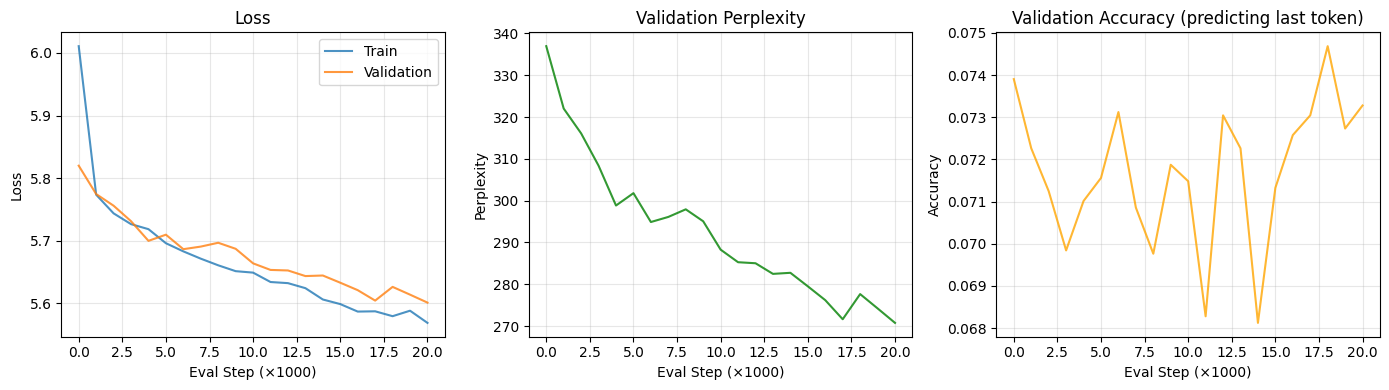


Final validation loss: 5.601
Final validation perplexity: 270.8
Final validation accuracy: 7.33%


In [10]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel('Eval Step (×1000)')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity
axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel('Eval Step (×1000)')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

# Accuracy
axes[2].plot(history['val_accuracy'], color='orange', alpha=0.8)
axes[2].set_xlabel('Eval Step (×1000)')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Validation Accuracy (predicting last token)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_training_curves.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")
print(f"Final validation accuracy: {history['val_accuracy'][-1]:.2%}")

---

## 5. Generation: The Moment of Truth

Let's see what our amoeba can do. Remember:
- Dream: "Lily"
- Win: "banana" (any noun)
- Expected: word soup

In [11]:
def generate_and_print(prompt, max_tokens=30):
    """Generate from a prompt and print results."""
    # Encode prompt (without EOS)
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    
    # Generate
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens)
    
    # Decode
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()
    
    return generated_tokens


print("=" * 60)
print("THE MOMENT OF TRUTH")
print("=" * 60)
print()

# The big test
_ = generate_and_print("Once upon a time there was a girl named")

THE MOMENT OF TRUTH

Prompt: Once upon a time there was a girl named
Generated:  One One Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet



In [12]:
# More tests
test_prompts = [
    "Once upon a time",
    "The little girl",
    "He was very",
    "She went to the",
    "They played with",
]

print("More generations:")
print("-" * 60)
for prompt in test_prompts:
    _ = generate_and_print(prompt, max_tokens=20)

More generations:
------------------------------------------------------------
Prompt: Once upon a time
Generated:  there named named One Oneetyetyetyetyetyetyetyetyetyetyetyetyetyetyety

Prompt: The little girl
Generated:  girl girl she girl her her her her her her her Her her herHerHer Her HerHerHer

Prompt: He was very
Generated:  excited. it. He He He He HeHe he his does heHe his He his heJimmy

Prompt: She went to the
Generated:  park park park " slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide

Prompt: They played with
Generated:  time namediskisk Whiskiskiskiskiskiskiskiskiskiskiskiskiskiskisk



In [13]:
def show_top_predictions(prompt, k=10):
    """Show the model's top-k predictions for what comes next."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    x = torch.tensor([prompt_tokens], device=device)
    
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=-1)[0]
    
    top_probs, top_indices = probs.topk(k)
    
    print(f"Prompt: '{prompt}'")
    print(f"Top {k} predictions:")
    for prob, idx in zip(top_probs, top_indices):
        token_str = tokenizer.decode_single(idx.item())
        print(f"  {prob.item():.3f}: {repr(token_str)}")
    print()


print("=" * 60)
print("TOP PREDICTIONS ANALYSIS")
print("=" * 60)
print()

show_top_predictions("Once upon a time there was a girl named")
show_top_predictions("Once upon a time")
show_top_predictions("The dog")

TOP PREDICTIONS ANALYSIS

Prompt: 'Once upon a time there was a girl named'
Top 10 predictions:
  0.841: ' One'
  0.159: ' named'
  0.000: ' loved'
  0.000: ' girl'
  0.000: ' lived'
  0.000: ' years'
  0.000: ' little'
  0.000: ' day'
  0.000: 'ety'
  0.000: ' Every'

Prompt: 'Once upon a time'
Top 10 predictions:
  0.961: ' there'
  0.039: ' named'
  0.000: ' time'
  0.000: ' One'
  0.000: ' upon'
  0.000: ' loved'
  0.000: ' lived'
  0.000: ' little'
  0.000: ' girl'
  0.000: ' a'

Prompt: 'The dog'
Top 10 predictions:
  1.000: ' dog'
  0.000: 'agged'
  0.000: ' w'
  0.000: ' boy'
  0.000: ' Spot'
  0.000: ' tail'
  0.000: 'icks'
  0.000: ' owner'
  0.000: ' bark'
  0.000: ' cat'



---

## 6. Analysis: What Did It Learn?

Let's understand what this model actually captured—and what it's missing.

In [14]:
# Look at embedding similarities
# Do semantically similar words have similar embeddings?

def get_similar_tokens(token_str, k=10):
    """Find tokens with similar embeddings."""
    # Get token ID
    token_ids = tokenizer.encode(token_str, add_eos=False)
    if not token_ids:
        print(f"Token not found: {token_str}")
        return
    
    token_id = token_ids[0]
    
    # Get all embeddings
    embeddings = model.embedding.weight.detach()  # [vocab_size, d_model]
    
    # Compute cosine similarities
    target_emb = embeddings[token_id]  # [d_model]
    similarities = F.cosine_similarity(target_emb.unsqueeze(0), embeddings, dim=1)
    
    # Get top-k (excluding the token itself)
    top_sims, top_indices = similarities.topk(k + 1)
    
    print(f"Tokens similar to '{token_str}':")
    for sim, idx in zip(top_sims[1:], top_indices[1:]):  # Skip self
        similar_token = tokenizer.decode_single(idx.item())
        print(f"  {sim.item():.3f}: {repr(similar_token)}")
    print()


# Check some semantically related words
get_similar_tokens(" happy")
get_similar_tokens(" girl")
get_similar_tokens(" dog")

Tokens similar to ' happy':
  0.575: 'From'
  0.557: ' From'
  0.548: ' played'
  0.467: 'After'
  0.439: ' end'
  0.435: 'Later'
  0.434: ' proud'
  0.404: ' helped'
  0.403: ' became'
  0.399: ' back'

Tokens similar to ' girl':
  0.487: ' She'
  0.354: ' years'
  0.350: ' little'
  0.330: ' easier'
  0.317: ' lied'
  0.315: 'aces'
  0.310: 'iest'
  0.309: ' three'
  0.300: ' Molly'
  0.292: ' anywhere'

Tokens similar to ' dog':
  0.542: ' bark'
  0.513: ' tail'
  0.444: 'ks'
  0.372: ' park'
  0.359: ' barking'
  0.348: 'Hey'
  0.339: ' brown'
  0.327: ' Spot'
  0.324: ' runs'
  0.312: ' black'



In [15]:
# Demonstrate position blindness
# These should give IDENTICAL predictions because the model doesn't see order

prompts_same_words = [
    "The girl saw the dog",
    "The dog saw the girl",  # Same words, different meaning!
]

print("Position blindness test:")
print("(These have the same words but different meanings)")
print("-" * 60)

for prompt in prompts_same_words:
    show_top_predictions(prompt, k=5)

Position blindness test:
(These have the same words but different meanings)
------------------------------------------------------------
Prompt: 'The girl saw the dog'
Top 5 predictions:
  0.981: ' dog'
  0.008: ' girl'
  0.001: ' the'
  0.001: '.'
  0.001: ' man'

Prompt: 'The dog saw the girl'
Top 5 predictions:
  0.981: ' dog'
  0.008: ' girl'
  0.001: ' the'
  0.001: '.'
  0.001: ' man'



---

## Summary

### What the Bag-of-Words Model Can Do:
- Learn which words are common in TinyStories
- Learn some word co-occurrence patterns (words that appear together)
- Generate text that has TinyStories "vibes"

### What It Cannot Do:
- Understand word order ("The dog bit the girl" = "The girl bit the dog")
- Complete phrases that depend on position ("named ___" should be a name)
- Generate grammatically coherent sentences

### The Lesson:
**Word identity isn't enough. Position matters.**

In notebook 02, we add positional encoding—giving the model information about *where* each word appears, not just *what* it is.

In [16]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'history': history,
}

torch.save(checkpoint, '01_bag_of_words.pt')
print("Model saved to 01_bag_of_words.pt")

Model saved to 01_bag_of_words.pt


In [17]:
print("=" * 60)
print("NOTEBOOK 01 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: Embed → Average → Unembed")
print(f"Parameters: {num_params:,}")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print(f"\nThe amoeba has been born. It's blind to position.")
print(f"Next: Give it eyes (positional encoding).")

NOTEBOOK 01 COMPLETE

Architecture: Embed → Average → Unembed
Parameters: 1,052,672
Final perplexity: 270.8

The amoeba has been born. It's blind to position.
Next: Give it eyes (positional encoding).
